### Method 1 

In [1]:
import numpy as np
import cv2
import math

In [2]:
img = cv2.imread('D:/RESEARCH/CONFERENCE/ICDAM_SPIE2023/IMAGES/histneworiginalImage.jpg')
gray = cv2.imread('D:/RESEARCH/CONFERENCE/ICDAM_SPIE2023/IMAGES/histneworiginalImage.jpg', 0)
blur = cv2.bilateralFilter(img,9,75,75)

In [3]:
#############################    HSI CONVERSION    ###########################

blur = np.divide(blur, 255.0)

hsi = np.zeros((blur.shape[0],blur.shape[1],blur.shape[2]),dtype=np.float)
ratio_map = np.zeros((blur.shape[0],blur.shape[1]),dtype=np.uint8)

for i in range(blur.shape[0]):
    for j in range(blur.shape[1]):
        hsi[i][j][2] = (blur[i][j][0]+blur[i][j][1]+blur[i][j][2])/3
        hsi[i][j][0] = math.acos(((blur[i][j][2]-blur[i][j][1])*(blur[i][j][2]-blur[i][j][0]))/(2*math.sqrt((blur[i][j][2]-blur[i][j][1])*(blur[i][j][2]-blur[i][j][1])+(blur[i][j][2]-blur[i][j][0])*(blur[i][j][1]-blur[i][j][0]))))
        hsi[i][j][1] = 1 - 3*min(blur[i][j][0],blur[i][j][1],blur[i][j][2])/hsi[i][j][2]
        ratio_map[i][j] = hsi[i][j][0]/(hsi[i][j][2]+0.01)                    

C:\Users\DOLONCHAPA\AppData\Local\Temp\ipykernel_30248\4266536428.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hsi = np.zeros((blur.shape[0],blur.shape[1],blur.shape[2]),dtype=np.float)
C:\Users\DOLONCHAPA\AppData\Local\Temp\ipykernel_30248\4266536428.py:11: RuntimeWarning: invalid value encountered in double_scalars
  hsi[i][j][0] = math.acos(((blur[i][j][2]-blur[i][j][1])*(blur[i][j][2]-blur[i][j][0]))/(2*math.sqrt((blur[i][j][2]-blur[i][j][1])*(blur[i][j][2]-blur[i][j][1])+(blur[i][j][2]-blur[i][j][0])*(blur[i][j][1]-blur[i][j][0]))))
C:\Users\DOLONCHAPA\AppData\Local\Temp\ipykernel_30248\4266536428.py:12: RuntimeWarning: invalid value encountered in d

In [4]:
#########################    OTSU'S METHOD    #################################

hist = np.histogram(ratio_map.ravel(),256,[0,256])
ret,th = cv2.threshold(ratio_map,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
median = cv2.medianBlur(th,15)
###############################################################################

In [6]:
cv2.imshow("original_image",img)
cv2.waitKey(0)

cv2.imshow("detected_shadow",median)
cv2.imwrite('D:/RESEARCH/CONFERENCE/ICDAM_SPIE2023/IMAGES/shadowDetected.jpg', median)

cv2.waitKey(0)
cv2.destroyAllWindows()

### Method 2 

In [7]:
import numpy as np
import cv2


In [8]:
# read an image with shadow...
# and it converts to BGR color space automatically
or_img = cv2.imread('D:/RESEARCH/CONFERENCE/ICDAM_SPIE2023/IMAGES/histneworiginalImage.jpg')

In [9]:
# covert the BGR image to an YCbCr image
y_cb_cr_img = cv2.cvtColor(or_img, cv2.COLOR_BGR2YCrCb)

In [10]:
# copy the image to create a binary mask later
binary_mask = np.copy(y_cb_cr_img)

In [11]:
# get mean value of the pixels in Y plane
y_mean = np.mean(cv2.split(y_cb_cr_img)[0])

In [12]:
# get standard deviation of channel in Y plane
y_std = np.std(cv2.split(y_cb_cr_img)[0])

In [13]:
# classify pixels as shadow and non-shadow pixels
for i in range(y_cb_cr_img.shape[0]):
    for j in range(y_cb_cr_img.shape[1]):

        if y_cb_cr_img[i, j, 0] < y_mean - (y_std / 3):
            # paint it white (shadow)
            binary_mask[i, j] = [255, 255, 255]
        else:
            # paint it black (non-shadow)
            binary_mask[i, j] = [0, 0, 0]

In [14]:
# Using morphological operation
# The misclassified pixels are
# removed using dilation followed by erosion.
kernel = np.ones((3, 3), np.uint8)
erosion = cv2.erode(binary_mask, kernel, iterations=1)

In [15]:
# sum of pixel intensities in the lit areas
spi_la = 0

# sum of pixel intensities in the shadow
spi_s = 0

In [16]:
# number of pixels in the lit areas
n_la = 0

# number of pixels in the shadow
n_s = 0

In [17]:
# get sum of pixel intensities in the lit areas
# and sum of pixel intensities in the shadow
for i in range(y_cb_cr_img.shape[0]):
    for j in range(y_cb_cr_img.shape[1]):
        if erosion[i, j, 0] == 0 and erosion[i, j, 1] == 0 and erosion[i, j, 2] == 0:
            spi_la = spi_la + y_cb_cr_img[i, j, 0]
            n_la += 1
        else:
            spi_s = spi_s + y_cb_cr_img[i, j, 0]
            n_s += 1

In [18]:
# get the average pixel intensities in the lit areas
average_ld = spi_la / n_la

# get the average pixel intensities in the shadow
average_le = spi_s / n_s

In [19]:
# difference of the pixel intensities in the shadow and lit areas
i_diff = average_ld - average_le

# get the ratio between average shadow pixels and average lit pixels
ratio_as_al = average_ld / average_le

In [20]:
# added these difference
for i in range(y_cb_cr_img.shape[0]):
    for j in range(y_cb_cr_img.shape[1]):
        if erosion[i, j, 0] == 255 and erosion[i, j, 1] == 255 and erosion[i, j, 2] == 255:

            y_cb_cr_img[i, j] = [y_cb_cr_img[i, j, 0] + i_diff, y_cb_cr_img[i, j, 1] + ratio_as_al,
                                 y_cb_cr_img[i, j, 2] + ratio_as_al]

In [21]:
# covert the YCbCr image to the BGR image
final_image = cv2.cvtColor(y_cb_cr_img, cv2.COLOR_YCR_CB2BGR)

In [22]:
cv2.imshow("im1", or_img)
cv2.imshow("im2", final_image)
cv2.imwrite('D:/RESEARCH/CONFERENCE/ICDAM_SPIE2023/IMAGES/ShadowM2.jpg', final_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Method 3 

In [23]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from copy import deepcopy
#from Pillow import Image

img_input= cv2.imread('D:/RESEARCH/CONFERENCE/ICDAM_SPIE2023/IMAGES/histneworiginalImage.jpg')# reads the rbg image
ycbcr_img=cv2.cvtColor(img_input, cv2.COLOR_RGB2YCrCb) # converts the rgb image to ycbcr color space

bin_mask = np.copy(ycbcr_img) #generates a numpy array which will be the binary mask to differentiate shadow and non shadow regions later
print(bin_mask.shape)

(2601, 2692, 3)


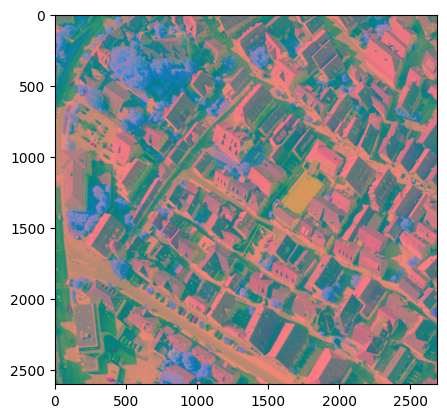

In [24]:
plt.imshow(ycbcr_img)
plt.show()
plt.imsave("D:/RESEARCH/CONFERENCE/ICDAM_SPIE2023/IMAGES/histnewYCbCr1.jpg", ycbcr_img)

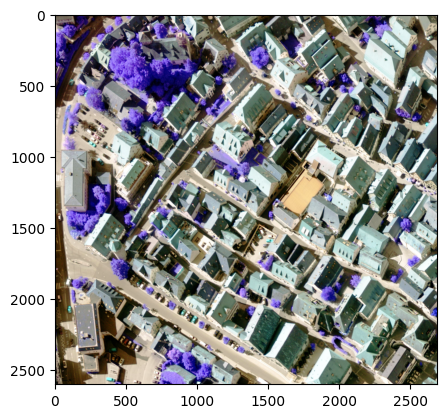

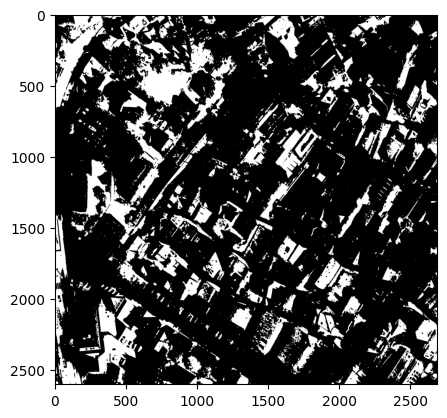

In [25]:
y_mean = np.mean(cv2.split(ycbcr_img)[0]) # computes the mean of Y channel

y_std = np.std(cv2.split(ycbcr_img)[0]) #computes the standard deviation of Y channel

for i in range(ycbcr_img.shape[0]):
    for j in range(ycbcr_img.shape[1]):

        if ycbcr_img[i, j, 0] < y_mean - y_std:
            bin_mask[i, j] = [255, 255, 255] #pixel is coloured white
        else:
            bin_mask[i, j] = [0, 0, 0] #pixel is coloured black
            
imgg = deepcopy(img_input)
for i in range(bin_mask.shape[0]):
    for j in range(bin_mask.shape[1]):

        if (bin_mask[i, j,0]== 255 and bin_mask[i, j,1]== 255 and bin_mask[i, j,2]== 255):
            imgg[i, j] = [255, 255, 255] #pixel is coloured white
        else:
            imgg[i, j] = [0, 0, 0] #pixel is coloured black

plt.imshow(img_input)
plt.show()
plt.imsave("D:/RESEARCH/CONFERENCE/ICDAM_SPIE2023/IMAGES/histnewImage.jpg", img_input)

plt.imshow(imgg)
plt.show()
plt.imsave("D:/RESEARCH/CONFERENCE/ICDAM_SPIE2023/IMAGES/histnewshadowMask1.jpg", imgg)

###  Method 4

In [26]:
import cv2
import gc
import numpy as np
import pandas as pd
import rasterio
from skimage.color import lab2lch, rgb2lab
from skimage.exposure import rescale_intensity
from skimage.morphology import disk
from sklearn.cluster import KMeans